In [1]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.io import read_image
import torchvision.transforms.functional as F
import cv2

In [2]:
#------importing the resnet model and setting the model to eval mode ----------
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
weights=ResNet50_Weights.IMAGENET1K_V1
model = resnet50(weights=weights)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
img1 = read_image('images/i1.jpg')
img2 = read_image('images/i2.jpg')
img3 = read_image('images/i3.jpg')
img4 = read_image('images/i4.jpg')
img5 = read_image('images/i5.jpg')


In [4]:
# -----------ReLU-------------------------------------
ReLU = lambda Z : torch.maximum(Z,torch.zeros_like(Z))
#-----------------------------------------------------

#------normalizing and increasing the dimension-----
preprocess = weights.transforms()
batch1 = preprocess(img1).unsqueeze(0)
batch2 = preprocess(img2).unsqueeze(0)
batch3 = preprocess(img3).unsqueeze(0)
batch4 = preprocess(img4).unsqueeze(0)
batch5 = preprocess(img5).unsqueeze(0)
#----------------------------------------------------

#---calculating the score and label of the images-----
prediction_1 = model(batch1).softmax(1)
class_id_1 = prediction_1.argmax()
score_1 = prediction_1[0][class_id_1].item()

prediction_2 = model(batch2).softmax(1)
class_id_2 = prediction_2.argmax()
score_2 = prediction_2[0][class_id_2].item()

prediction_3 = model(batch3).softmax(1)
class_id_3 = prediction_3.argmax()
score_3 = prediction_3[0][class_id_3].item()

prediction_4 = model(batch4).softmax(1)
class_id_4 = prediction_4.argmax()
score_4 = prediction_4[0][class_id_4].item()

prediction_5 = model(batch5).softmax(1)
class_id_5 = prediction_5.argmax()
score_5 = prediction_5[0][class_id_5].item()
#-----------------------------------------------------

#-------check the score and label index wise(i1->1) ----------------------------
argscore = torch.tensor([class_id_1,class_id_2,class_id_3,class_id_4,class_id_5])
maxscore = torch.tensor([score_1,score_2,score_3,score_4,score_5])
argscore,maxscore

(tensor([235,  65, 822, 851, 282]),
 tensor([0.5792, 0.4450, 0.9953, 0.1701, 0.6839]))

In [5]:
#----------names of the model layers------
# fc layer has index 9
children_counter = 0
for n,c in model.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1

Children Counter:  0  Layer Name:  conv1
Children Counter:  1  Layer Name:  bn1
Children Counter:  2  Layer Name:  relu
Children Counter:  3  Layer Name:  maxpool
Children Counter:  4  Layer Name:  layer1
Children Counter:  5  Layer Name:  layer2
Children Counter:  6  Layer Name:  layer3
Children Counter:  7  Layer Name:  layer4
Children Counter:  8  Layer Name:  avgpool
Children Counter:  9  Layer Name:  fc


In [6]:
from torch import nn

#--------------vanilla backprop --------------------
#finding the gradients with respect to image
#backward() is used to calculate the gradients
#setting the requires_grad of input image to True
def vanilla_backprop(img,label):
    image = img.clone()
    image.requires_grad = True
    model.eval()
    y_pred = model(image)
    output = torch.zeros_like(y_pred,dtype = torch.float32)
    output[0][label] = 1
    y_pred.backward(gradient=output)
    return image.grad

#--------------guided backprop --------------------
#the code is same as the vanilla backprop
#here only positive gradients are passed back
#this is done by hooks
#a backward is registered in guided backprop cell which makes passes only positive gradients
def guided_backprop(img,label):
    image = img.clone()
    image.requires_grad = True
    model.eval()
    y_pred = model(image)
    output = torch.zeros_like(y_pred,dtype = torch.float32)
    output[0][label] = 1
    y_pred.backward(gradient=output)
    return image.grad

#----------accessing the weights of gap layer and fully connected layer -------
#children() gives the model layers
#declared as global variable
a = list(model.children())
weight = a[9].weight


#gives the output of the last convolution layer------------
#a forward hook is used
#my_hook is stores the output of the last convolution layer during forward propagation
def gap_input(img):
    with torch.no_grad():
        my_output = None
        
        def my_hook(module_, input_, output_):
            nonlocal my_output
            my_output = output_

        a_hook = model.layer4.register_forward_hook(my_hook)        
        model(img)
        a_hook.remove()
        return my_output
    
#------class activation maps---------
def cam(img,label):
    image = img.clone()
    image.requires_grad = True
    output = gap_input(image)
    output = output[0].permute(1,2,0)
    for i in range(2048):
        output[:,:,i] = output[:,:,i]*weight[label][i]

    output = torch.sum(output,axis =2)
    output = output.unsqueeze(0)
    #resizing the (7,7) to (224,224)
    new_output = F.resize(output, size=(224, 224))
    new_output = new_output.permute(1,2,0).detach()
    return new_output

#----------guided grad_cam ---------
# backward() is used to calculate the gradients
#a backward hook registered in guided gradcam cell to store the gradients wrt to layer before gap layer
#gradients is declared in guided gradcam cell
# return average of gradients(global average pooling)
def guided_grad_cam(img,label):
    image = img.clone()
    image.requires_grad = True
    model.eval()
    y_pred = model(image)
    output = torch.zeros_like(y_pred,dtype = torch.float32)
    output[0][label] = 1
    y_pred.backward(gradient=output)
    pool_layer = model.avgpool
    return pool_layer(gradients[0])
    
#--------guided grad cam continuation -----------
# averaged gradients are multiplied with the layer before gap layer
def guided_grad_func(img,alpha):
    img = img.clone()
    alpha = alpha.resize(2048)
    output = img.clone()
    output = output[0].permute(1,2,0)
    output = output.detach()
    for i in range(2048):
        output[:,:,i] = output[:,:,i]*alpha[i]
    output = torch.sum(output,axis =2)
    #ReLU is used(in grad cam)
    output = ReLU(output)
    output = output.unsqueeze(0)
    #resizing the (7,7) to (224,224)
    new_output = F.resize(output, size=(224, 224))
    new_output = new_output.permute(1,2,0).detach().numpy()
    return new_output

#normalizing any tensor to contain values between [0,1]
def normalize(img_1):
    img_1 = (img_1 - torch.min(img_1))/(torch.max(img_1)-torch.min(img_1))
    return img_1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


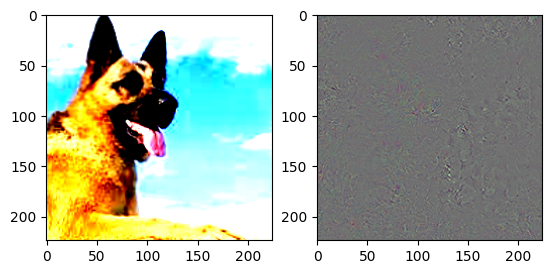

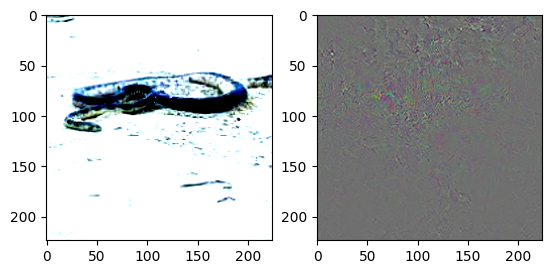

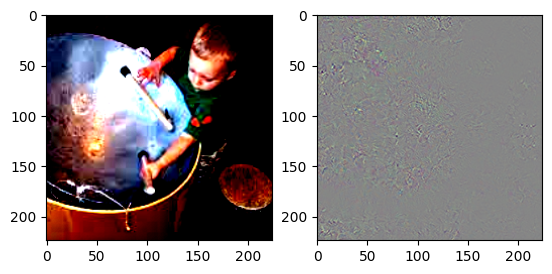

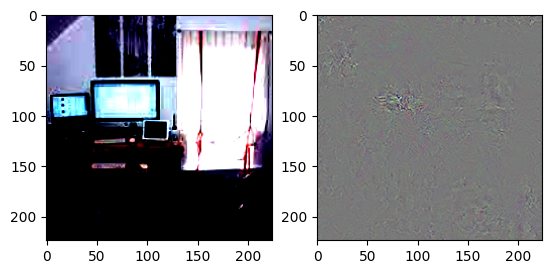

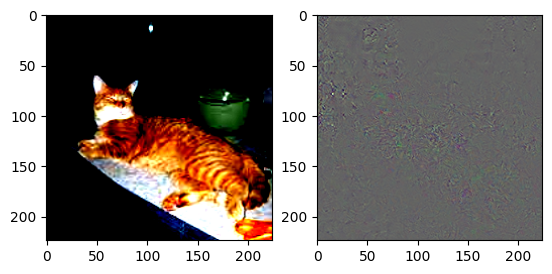

In [7]:
img_1 = vanilla_backprop(batch1,argscore[0])
img_1 = normalize(img_1)
fig1,ax1 = plt.subplots(1,2)
ax1[0].imshow(batch1[0].permute(1,2,0))
ax1[1].imshow(img_1[0].permute(1,2,0))

img_2 = vanilla_backprop(batch2,argscore[1])
img_2 = normalize(img_2)
fig2,ax2 = plt.subplots(1,2)
ax2[0].imshow(batch2[0].permute(1,2,0))
ax2[1].imshow(img_2[0].permute(1,2,0))


img_3 = vanilla_backprop(batch3,argscore[2])
img_3 = normalize(img_3)
fig3,ax3 = plt.subplots(1,2)
ax3[0].imshow(batch3[0].permute(1,2,0))
ax3[1].imshow(img_3[0].permute(1,2,0))

img_4 = vanilla_backprop(batch4,argscore[3])
img_4 = normalize(img_4)
fig4,ax4 = plt.subplots(1,2)
ax4[0].imshow(batch4[0].permute(1,2,0))
ax4[1].imshow(img_4[0].permute(1,2,0))

img_5 = vanilla_backprop(batch5,argscore[4])
img_5 = normalize(img_5)
fig5,ax5 = plt.subplots(1,2)
ax5[0].imshow(batch5[0].permute(1,2,0))
ax5[1].imshow(img_5[0].permute(1,2,0))

/home/karthik/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


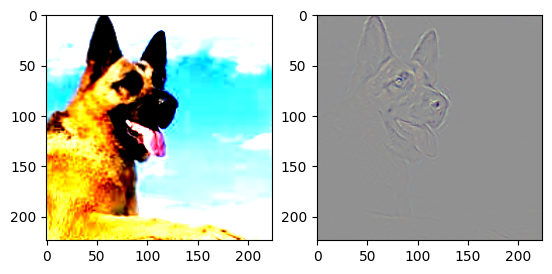

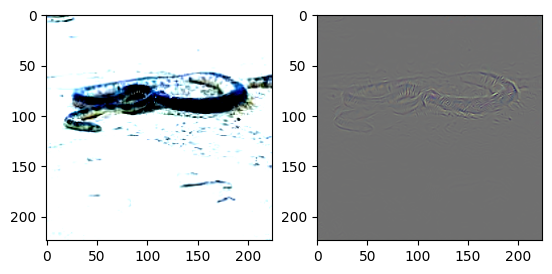

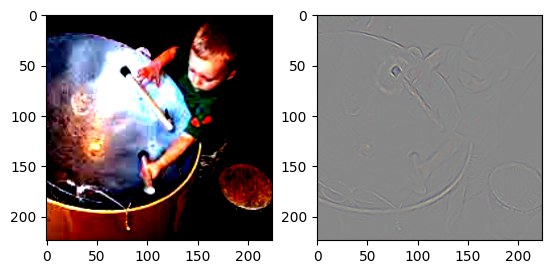

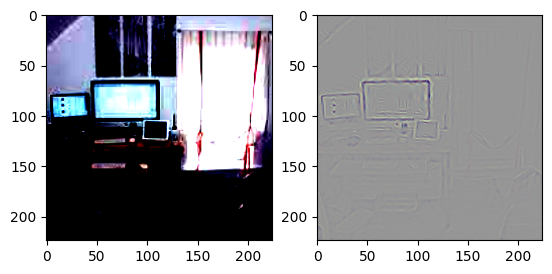

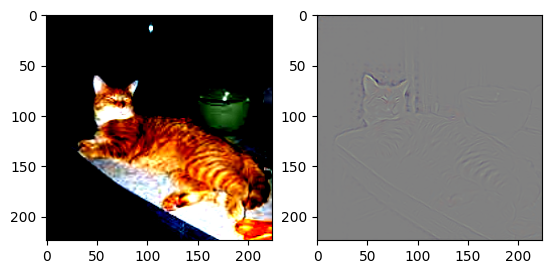

In [8]:
#---------hook function---------
#relu_hook function make sure to pass only postive graidents
#negative gradients are made to 0
def relu_hook(module,grad_input,grad_output):
    grad_input = list(grad_input)
    grad_input[0] = ReLU(grad_input[0])
    grad_input = tuple(grad_input)
    return grad_input

# adding the relu_hook to only relu containing layers
handles = []
for name,module in model.named_modules():
    if isinstance(module,torch.nn.modules.activation.ReLU):
        handles.append(module.register_backward_hook(relu_hook))

img_1 = guided_backprop(batch1,argscore[0])
g_img_1 = img_1
fig1,ax1 = plt.subplots(1,2)
ax1[0].imshow(batch1[0].permute(1,2,0))
ax1[1].imshow(normalize(g_img_1[0]).permute(1,2,0))

img_2 = guided_backprop(batch2,argscore[1])
g_img_2 = img_2
fig2,ax2 = plt.subplots(1,2)
ax2[0].imshow(batch2[0].permute(1,2,0))
ax2[1].imshow(normalize(g_img_2[0]).permute(1,2,0))


img_3 = guided_backprop(batch3,argscore[2])
g_img_3 = img_3
fig3,ax3 = plt.subplots(1,2)
ax3[0].imshow(batch3[0].permute(1,2,0))
ax3[1].imshow(normalize(g_img_3[0]).permute(1,2,0))

img_4 = guided_backprop(batch4,argscore[3])
g_img_4 = img_4
fig4,ax4 = plt.subplots(1,2)
ax4[0].imshow(batch4[0].permute(1,2,0))
ax4[1].imshow(normalize(g_img_4[0]).permute(1,2,0))

img_5 = guided_backprop(batch5,argscore[4])
g_img_5 = img_5
fig5,ax5 = plt.subplots(1,2)
ax5[0].imshow(batch5[0].permute(1,2,0))
ax5[1].imshow(normalize(g_img_5[0]).permute(1,2,0))
for handle in handles:
    handle.remove()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

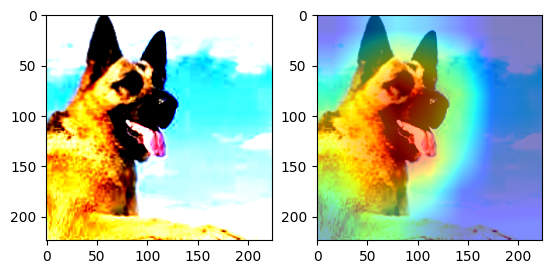

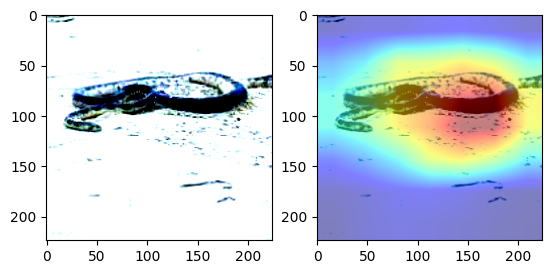

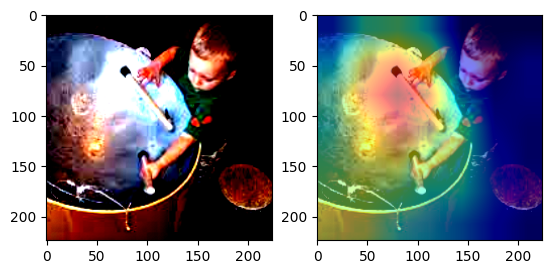

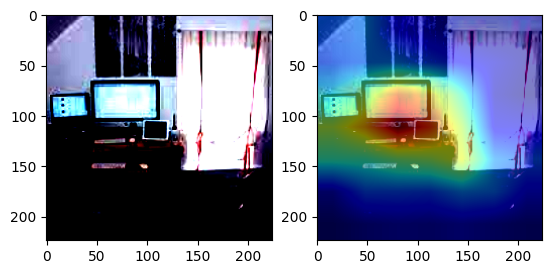

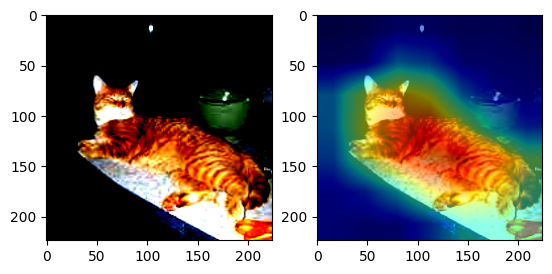

In [9]:
img_1 = cam(batch1,argscore[0])
img_1 = normalize(img_1)
fig1,ax1 = plt.subplots(1,2)
ax1[0].imshow(batch1[0].permute(1,2,0))
ax1[1].imshow(img_1,cmap = "jet")
ax1[1].imshow(batch1[0].permute(1,2,0),alpha = 0.5)

img_2 = cam(batch2,argscore[1])
img_2 = normalize(img_2)
fig2,ax2 = plt.subplots(1,2)
ax2[0].imshow(batch2[0].permute(1,2,0))
ax2[1].imshow(img_2,cmap = "jet")
ax2[1].imshow(batch2[0].permute(1,2,0),alpha = 0.5)

img_3 = cam(batch3,argscore[2])
img_3 = normalize(img_3)
fig3,ax3 = plt.subplots(1,2)
ax3[0].imshow(batch3[0].permute(1,2,0))
ax3[1].imshow(img_3,cmap = "jet")
ax3[1].imshow(batch3[0].permute(1,2,0),alpha = 0.5)

img_4 = cam(batch4,argscore[3])
img_4 = normalize(img_4)
fig4,ax4 = plt.subplots(1,2)
ax4[0].imshow(batch4[0].permute(1,2,0))
ax4[1].imshow(img_4,cmap = "jet")
ax4[1].imshow(batch4[0].permute(1,2,0),alpha = 0.5)

img_5 = cam(batch5,argscore[4])
img_5 = normalize(img_5)
fig5,ax5 = plt.subplots(1,2)
ax5[0].imshow(batch5[0].permute(1,2,0))
ax5[1].imshow(img_5,cmap = "jet")
ax5[1].imshow(batch5[0].permute(1,2,0),alpha = 0.5)

/home/karthik/.local/lib/python3.10/site-packages/torch/_tensor.py:760: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/tmp/ipykernel_8132/3999530859.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_1 = normalize(torch.tensor(img_1))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


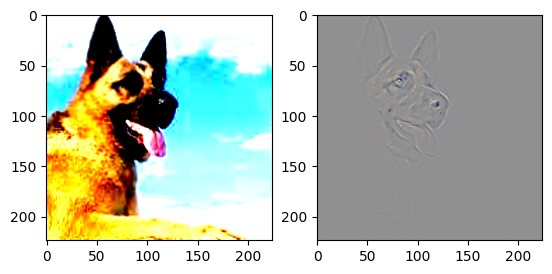

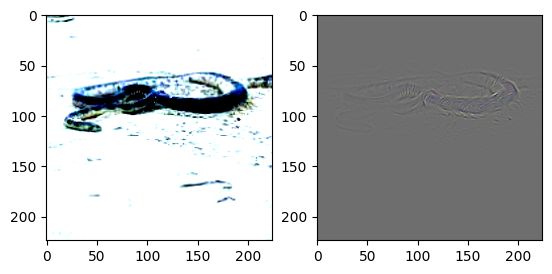

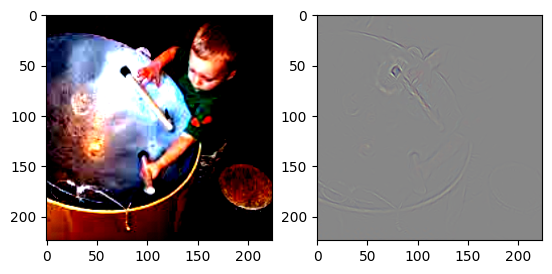

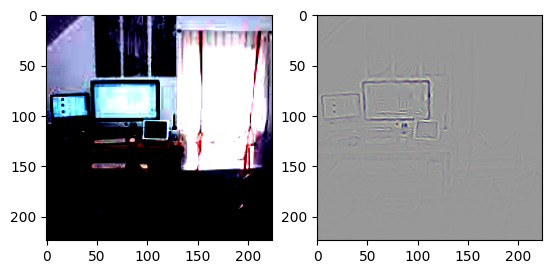

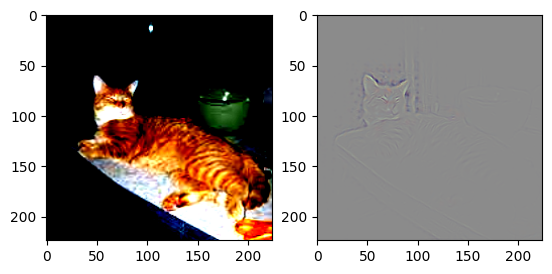

In [10]:
gradients = []
#conv_graident is a hook function which stores the gradient wrt to the layer before the gap layer
#backward hook
def conv_gradient(module, grad_input, grad_output):
    gradients.append(grad_output[0])

hook = model.layer4.register_backward_hook(conv_gradient)

alpha_1 = guided_grad_cam(batch1,argscore[0]) # gradients of layer 4 shape(1,2048,1,1)
conv_1 = gap_input(batch1) # output of layer 4
img_1 = guided_grad_func(conv_1,alpha_1)
# l_img_1 = list(torch.max(g_img_1,dim=0)[0])
# l_img_1[0] = l_img_1[0].unsqueeze(0)
img_1 = torch.mul(torch.tensor(img_1),g_img_1[0].permute(1,2,0))
img_1 = normalize(torch.tensor(img_1))
fig1,ax1 = plt.subplots(1,2)
ax1[0].imshow(batch1[0].permute(1,2,0))
ax1[1].imshow(img_1)

gradients = []
alpha_2 = guided_grad_cam(batch2,argscore[1])
conv_2 = gap_input(batch2)
img_2 = guided_grad_func(conv_2,alpha_2)
# l_img_2 = list(torch.max(g_img_2,dim=0)[0])
# l_img_2[0] = l_img_2[0].unsqueeze(0)
img_2 = torch.mul(torch.tensor(img_2),g_img_2[0].permute(1,2,0))
img_2 = normalize(img_2)
fig2,ax2 = plt.subplots(1,2)
ax2[0].imshow(batch2[0].permute(1,2,0))
ax2[1].imshow(img_2)

gradients = []
alpha_3 = guided_grad_cam(batch3,argscore[2])
conv_3 = gap_input(batch3)
img_3 = guided_grad_func(conv_3,alpha_3)
# l_img_3 = list(torch.max(g_img_3,dim=0)[0])
# l_img_3[0] = l_img_3[0].unsqueeze(0)
img_3 = torch.mul(torch.tensor(img_3),g_img_3[0].permute(1,2,0))
img_3 = normalize(img_3)
fig3,ax3 = plt.subplots(1,2)
ax3[0].imshow(batch3[0].permute(1,2,0))
ax3[1].imshow(img_3)

gradients = []
alpha_4 = guided_grad_cam(batch4,argscore[3])
conv_4 = gap_input(batch4)
img_4 = guided_grad_func(conv_4,alpha_4)
# l_img_4 = list(torch.max(g_img_4,dim=0)[0])
# l_img_4[0] = l_img_4[0].unsqueeze(0)
img_4 = torch.mul(torch.tensor(img_4),g_img_4[0].permute(1,2,0))
img_4 = normalize(img_4)
fig4,ax4 = plt.subplots(1,2)
ax4[0].imshow(batch4[0].permute(1,2,0))
ax4[1].imshow(img_4)


alpha_5 = guided_grad_cam(batch2,argscore[4])
conv_5 = gap_input(batch5)
img_5 = guided_grad_func(conv_5,alpha_5)
# l_img_5 = list(torch.max(g_img_5,dim=0)[0])
# l_img_5[0] = l_img_5[0].unsqueeze(0)
img_5 = torch.mul(torch.tensor(img_5),g_img_5[0].permute(1,2,0))
img_5 = normalize(img_5)
fig5,ax5 = plt.subplots(1,2)
ax5[0].imshow(batch5[0].permute(1,2,0))
ax5[1].imshow(img_5)
hook.remove()